In [1]:
import os 
import json
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

tf.config.list_physical_devices()

2025-02-22 22:26:07.664683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 22:26:07.673850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 22:26:07.685272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 22:26:07.688745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 22:26:07.696846: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

I0000 00:00:1740237970.425700   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740237970.425909   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
CHARTS = ["Bar", "Line", "Pie"]
EPOCHS = 20
BATCH_SIZE = 32

In [4]:
cls_train_images = "../../assets/dataset/reduced_data/clsdata(1031)/cls/images/train2019/"
cls_val_images = "../../assets/dataset/reduced_data/clsdata(1031)/cls/images/val2019/"
cls_test_images = "../../assets/dataset/reduced_data/clsdata(1031)/cls/images/test2019/"

cls_train_annotations = "../../assets/dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_train2019.json"
cls_val_annotations = "../../assets/dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_val2019.json"
cls_test_annotations = "../../assets/dataset/reduced_data/clsdata(1031)/cls/annotations/instancesCls(1031)_test2019.json"

In [5]:
with open(cls_test_annotations) as f:
    cls_test_data = json.load(f)
    test_annotations_df = pd.DataFrame(cls_test_data['images'])
    test_annotations_df['data_type'] = test_annotations_df['data_type'].astype(str)
    
with open(cls_train_annotations) as f:
    cls_train_data = json.load(f)
    train_annotations_df = pd.DataFrame(cls_train_data['images'])
    train_annotations_df['data_type'] = train_annotations_df['data_type'].astype(str)
    
with open(cls_val_annotations) as f:
    cls_val_data = json.load(f)
    val_annotations_df = pd.DataFrame(cls_val_data['images'])
    val_annotations_df['data_type'] = val_annotations_df['data_type'].astype(str)

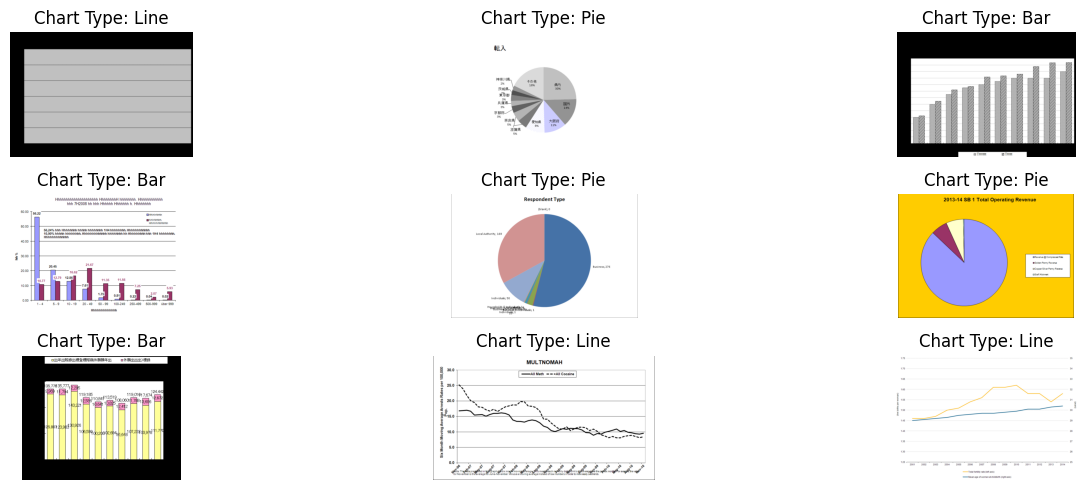

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
axes = axes.ravel()

for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(train_annotations_df))
    img_path = os.path.join(cls_train_images, train_annotations_df.iloc[idx]['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    chart_type = train_annotations_df.iloc[idx]['data_type']
    
    ax.set_title(f"Chart Type: {CHARTS[int(chart_type)]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = datagen.flow_from_dataframe(
    train_annotations_df,
    directory=cls_train_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    val_annotations_df,
    directory=cls_val_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_annotations_df,
    directory=cls_test_images,
    x_col='file_name',
    y_col='data_type', 
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 20000 validated image filenames belonging to 3 classes.
Found 1000 validated image filenames belonging to 3 classes.
Found 1000 validated image filenames belonging to 3 classes.


In [82]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [84]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    GlobalMaxPool2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_5          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,946,883 (11.24 MB)

 Trainable params: 2,912,771 (11.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [85]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3
)

checkpoint = ModelCheckpoint(
    'model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [86]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 165ms/step - accuracy: 0.9315 - loss: 0.4509 - val_accuracy: 0.7000 - val_loss: 1.0441
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.9847 - loss: 0.0750 - val_accuracy: 0.8910 - val_loss: 2.1591
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.9924 - loss: 0.0348 - val_accuracy: 0.7250 - val_loss: 10.2235
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.9953 - loss: 0.0203 - val_accuracy: 0.9630 - val_loss: 0.7249
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.9684 - loss: 0.1388 - val_accuracy: 0.3450 - val_loss: 40.1294
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.9912 - loss: 0.0353 - val_accuracy: 0.6710 - val_loss: 17.2374
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.9938 - loss: 0.0264 - val_accuracy: 0.3600 - val_loss: 14.2474
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 161ms/step - accuracy: 0.98

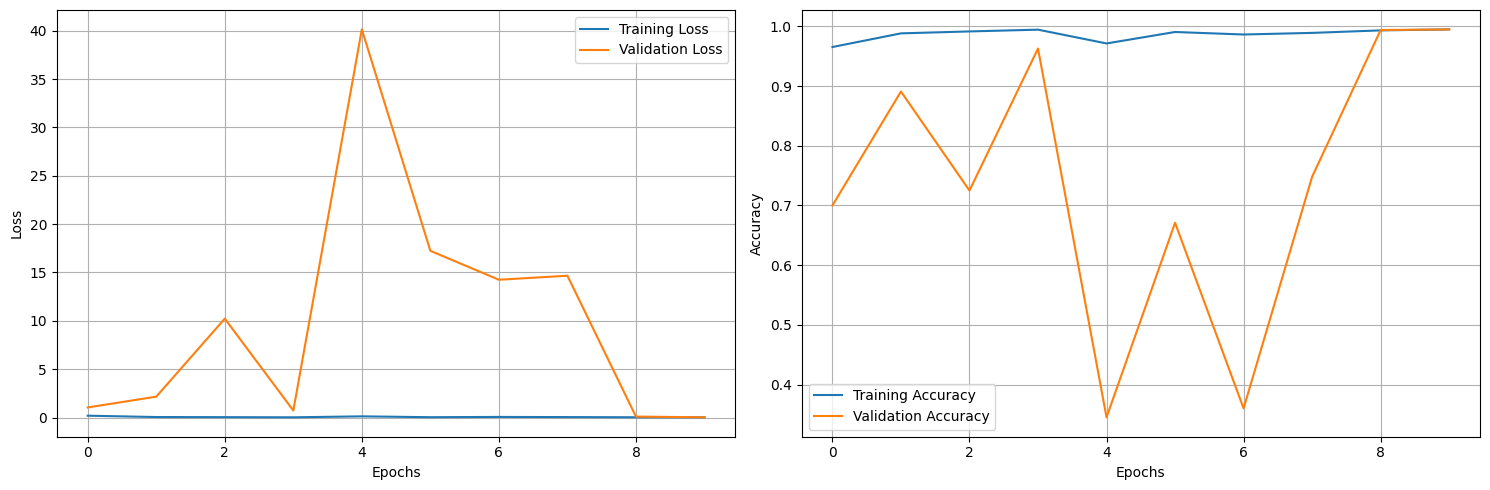

In [87]:
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_df['loss'], label='Training Loss')
axes[0].plot(history_df['val_loss'], label='Validation Loss')

axes[1].plot(history_df['accuracy'], label='Training Accuracy')
axes[1].plot(history_df['val_accuracy'], label='Validation Accuracy')

for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlabel('Epochs')

axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [92]:
# Save model.keras
model.save('model.keras')

In [8]:
# Load the model
model = tf.keras.models.load_model('model.keras')
# Evaluate the model
model.evaluate(test_generator)

I0000 00:00:1740237994.583981   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740237994.584243   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740237994.584343   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740237994.638677   98046 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 2/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9922 - loss: 0.0158     

I0000 00:00:1740238006.365110   98363 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.9904 - loss: 0.0222


[0.028777074068784714, 0.9909999966621399]

In [9]:
# Reset the generator before prediction
test_generator.reset()

# Get predictions
preds = model.predict(test_generator)

# Reset again to get actual labels in correct order
test_generator.reset()

# Get the true labels
true_labels = test_generator.labels

# Get predicted labels
pred_labels = np.argmax(preds, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
print("Sklearn accuracy:", accuracy_score(true_labels, pred_labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step
Sklearn accuracy: 0.991


In [12]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       330
           1       0.99      0.99      0.99       330
           2       0.99      0.99      0.99       340

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



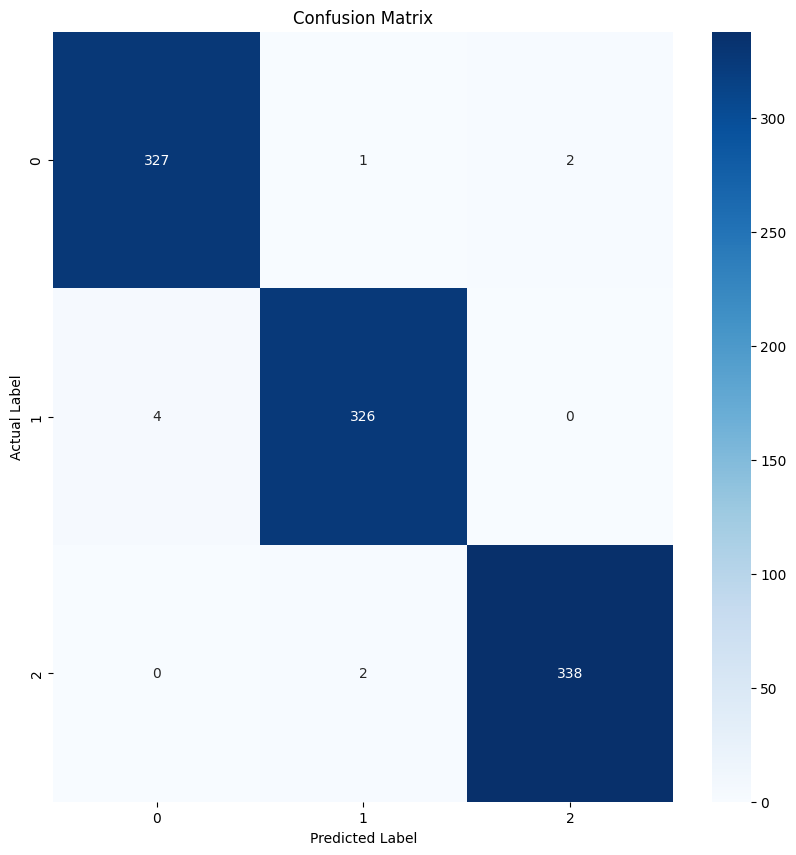

In [14]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

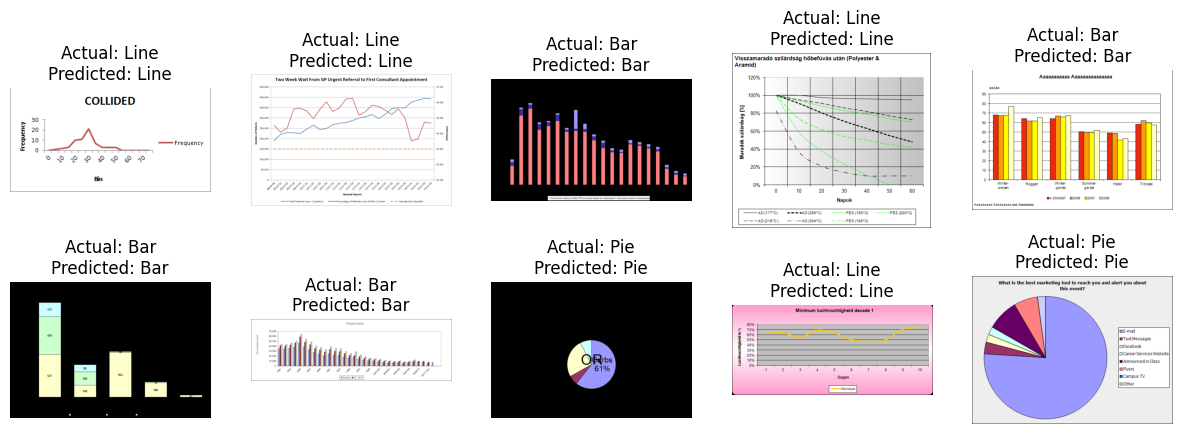

In [16]:
# Show 10 random images with their predicted and actual chart type
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.ravel()

for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(test_annotations_df))
    img_path = os.path.join(cls_test_images, test_annotations_df.iloc[idx]['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    chart_type = test_annotations_df.iloc[idx]['data_type']
    predicted = pred_labels[idx]
    
    ax.set_title(f"Actual: {CHARTS[int(chart_type)]}\nPredicted: {CHARTS[predicted]}")
    ax.axis('off')